In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [3]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(20), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(20)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.2, seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                               
0.9366868800000001                                   
ERROR                                                
0.0013534375955656492                                
SCORE:                                                                         
0.93654578                                                                     
ERROR                                                                          
0.0015742622488709754                                                          
SCORE:                                                                         
0.93558732                                                                     
ERROR                                                                          
0.0015204070846817426                                                          
SCORE:                                                                         
0.9332793199999999                                              

0.93677056                                                                      
ERROR                                                                           
0.0020168842512823617                                                           
SCORE:                                                                          
0.9351282599999999                                                              
ERROR                                                                           
0.0016902568074894642                                                           
SCORE:                                                                          
0.9371290199999999                                                              
ERROR                                                                           
0.0016975964864931678                                                           
SCORE:                                                                          
0.9363729600000001          

ERROR                                                                           
0.0015765940476310234                                                           
SCORE:                                                                          
0.9313167000000002                                                              
ERROR                                                                           
0.0016202923137212239                                                           
SCORE:                                                                          
0.9369019399999999                                                              
ERROR                                                                           
0.0020217225752629416                                                           
SCORE:                                                                          
0.93635428                                                                      
ERROR                       

0.0017295422918743232                                                           
SCORE:                                                                          
0.93611884                                                                      
ERROR                                                                           
0.0016778246081334436                                                           
SCORE:                                                                          
0.93692814                                                                      
ERROR                                                                           
0.0018824041972324893                                                           
SCORE:                                                                          
0.9358333200000001                                                              
ERROR                                                                           
0.0014789921652014336       

# max_depth controls depth of trees

12 lets the model use all the features and improvements seem minor beyond that

Text(0, 0.5, 'CV AUC')

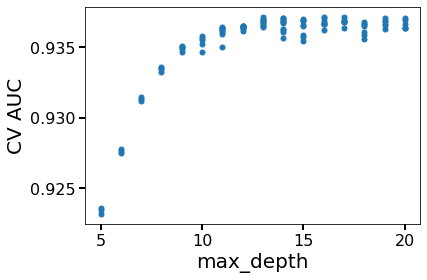

In [6]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
aucs = np.array([1-x['loss'] for x in trials.results])

fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

# min child weight acts as a regularizer, penalizing complex models. Larger min_child_weight = larger penalization

Text(0, 0.5, 'CV AUC')

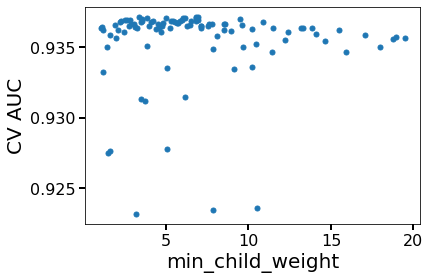

In [7]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Text(0, 0.5, 'min_child_weight')

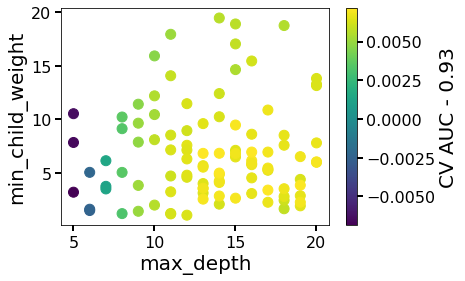

In [8]:
fig, ax = plt.subplots()
cb = ax.scatter(depths, min_childs, c=aucs-0.93)
plt.colorbar(cb, label='CV AUC - 0.93')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')

# Marginal improvements beyond max_depth of 13, so choose the least complex model

In [9]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.94833+0.00063	test-auc:0.92236+0.00232
[1]	train-auc:0.95519+0.00085	test-auc:0.92906+0.00240
[2]	train-auc:0.95877+0.00077	test-auc:0.93213+0.00227
[3]	train-auc:0.96047+0.00080	test-auc:0.93357+0.00225
[4]	train-auc:0.96218+0.00043	test-auc:0.93476+0.00219
[5]	train-auc:0.96384+0.00052	test-auc:0.93629+0.00208
[6]	train-auc:0.96490+0.00025	test-auc:0.93699+0.00229
[7]	train-auc:0.96593+0.00023	test-auc:0.93782+0.00212
[8]	train-auc:0.96684+0.00033	test-auc:0.93845+0.00209
[9]	train-auc:0.96760+0.00027	test-auc:0.93892+0.00195
[10]	train-auc:0.96845+0.00038	test-auc:0.93948+0.00195
[11]	train-auc:0.96915+0.00035	test-auc:0.93983+0.00212
[12]	train-auc:0.96987+0.00025	test-auc:0.94029+0.00209
[13]	train-auc:0.97049+0.00029	test-auc:0.94061+0.00197
[14]	train-auc:0.97106+0.00029	test-auc:0.94098+0.00187
[15]	train-auc:0.97164+0.00026	test-auc:0.94123+0.00194
[16]	train-auc:0.97211+0.00024	test-auc:0.94151+0.00189
[17]	train-auc:0.97256+0.00025	test-auc:0.94170+0.00187
[1

[146]	train-auc:0.99198+0.00020	test-auc:0.95106+0.00123
[147]	train-auc:0.99204+0.00021	test-auc:0.95109+0.00125
[148]	train-auc:0.99209+0.00022	test-auc:0.95110+0.00125
[149]	train-auc:0.99215+0.00023	test-auc:0.95112+0.00125
[150]	train-auc:0.99218+0.00023	test-auc:0.95113+0.00126
[151]	train-auc:0.99223+0.00024	test-auc:0.95117+0.00127
[152]	train-auc:0.99230+0.00024	test-auc:0.95118+0.00128
[153]	train-auc:0.99235+0.00025	test-auc:0.95121+0.00127
[154]	train-auc:0.99242+0.00024	test-auc:0.95125+0.00126
[155]	train-auc:0.99248+0.00024	test-auc:0.95128+0.00125
[156]	train-auc:0.99255+0.00021	test-auc:0.95131+0.00124
[157]	train-auc:0.99261+0.00018	test-auc:0.95135+0.00122
[158]	train-auc:0.99268+0.00018	test-auc:0.95137+0.00122
[159]	train-auc:0.99271+0.00018	test-auc:0.95138+0.00121
[160]	train-auc:0.99275+0.00018	test-auc:0.95139+0.00121
[161]	train-auc:0.99280+0.00018	test-auc:0.95142+0.00123
[162]	train-auc:0.99286+0.00019	test-auc:0.95145+0.00122
[163]	train-auc:0.99289+0.00018

[290]	train-auc:0.99682+0.00005	test-auc:0.95314+0.00114
[291]	train-auc:0.99684+0.00005	test-auc:0.95314+0.00115
[292]	train-auc:0.99686+0.00004	test-auc:0.95315+0.00115
[293]	train-auc:0.99687+0.00005	test-auc:0.95316+0.00114
[294]	train-auc:0.99689+0.00005	test-auc:0.95316+0.00114
[295]	train-auc:0.99690+0.00005	test-auc:0.95317+0.00114
[296]	train-auc:0.99690+0.00005	test-auc:0.95317+0.00115
[297]	train-auc:0.99691+0.00005	test-auc:0.95318+0.00115
[298]	train-auc:0.99693+0.00005	test-auc:0.95318+0.00114
[299]	train-auc:0.99695+0.00005	test-auc:0.95319+0.00115
[300]	train-auc:0.99698+0.00004	test-auc:0.95320+0.00115
[301]	train-auc:0.99699+0.00004	test-auc:0.95321+0.00114
[302]	train-auc:0.99701+0.00004	test-auc:0.95321+0.00114
[303]	train-auc:0.99702+0.00004	test-auc:0.95322+0.00114
[304]	train-auc:0.99705+0.00005	test-auc:0.95323+0.00114
[305]	train-auc:0.99706+0.00005	test-auc:0.95324+0.00114
[306]	train-auc:0.99708+0.00005	test-auc:0.95324+0.00113
[307]	train-auc:0.99710+0.00004

# Going beyond ~100 trees does not improve CV, so cut off training there to avoid overfitting

Text(0, 0.5, 'CV AUC score')

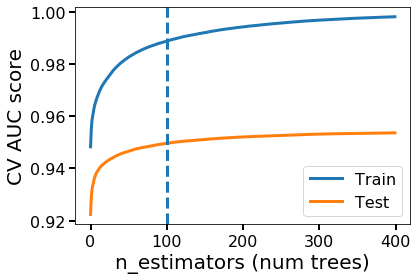

In [10]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [11]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=13,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method=None, validate_parameters=False, verbosity=None)

In [12]:
model.save_model(datapath+'../spock/models/spock.json')

In [13]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/spock.json')

# SPOCK

Text(0.5, 1.0, 'ROC curve (AUC = 0.953)')

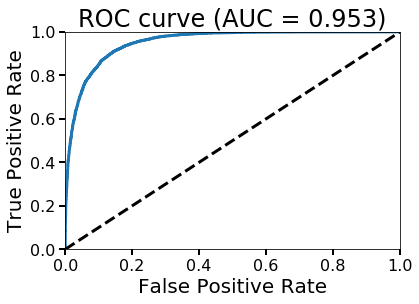

In [14]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [15]:
stride = 10
np.savetxt('../spock/models/resROC.txt', (ROCthresholds[::stride], tpr[::stride], fpr[::stride]))

In [16]:
ROCthresholds, tpr, fpr = np.loadtxt('../spock/models/resROC.txt')
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9896588325500488, TPR = 0.0, FPR = 0.0
Threshold 0.8918883800506592, TPR = 0.2820996978851964, FPR = 0.004364555217366336
Threshold 0.8338184356689453, TPR = 0.408987915407855, FPR = 0.009245965657841842
Threshold 0.7911725640296936, TPR = 0.47658610271903323, FPR = 0.01418480445644059
Threshold 0.745854914188385, TPR = 0.5404078549848943, FPR = 0.019525641761902027
Threshold 0.705155074596405, TPR = 0.589690332326284, FPR = 0.025211049216102913
Threshold 0.6644747257232666, TPR = 0.6355740181268882, FPR = 0.031183598460920003
Threshold 0.6241954565048218, TPR = 0.6714501510574018, FPR = 0.03790271636133923
Threshold 0.5779088735580444, TPR = 0.7063821752265861, FPR = 0.044449549187388734
Threshold 0.5285456776618958, TPR = 0.7379154078549849, FPR = 0.05243209096651927
Threshold 0.48045119643211365, TPR = 0.771714501510574, FPR = 0.060931487968758975
Threshold 0.43897873163223267, TPR = 0.7938066465256798, FPR = 0.07184287601217482
Threshold 0.3960135579109192, TPR = 0.8164

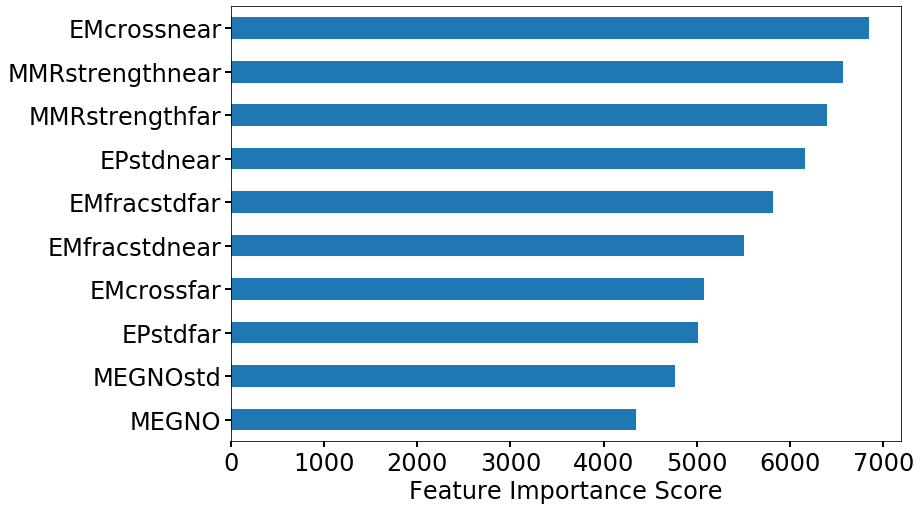

In [17]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [18]:
feat_imp

EMcrossnear        6844
MMRstrengthnear    6568
MMRstrengthfar     6392
EPstdnear          6161
EMfracstdfar       5815
EMfracstdnear      5509
EMcrossfar         5077
EPstdfar           5009
MEGNOstd           4763
MEGNO              4350
dtype: int64

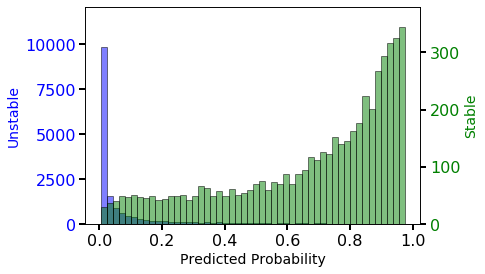

In [19]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100
fig.savefig('stable_unstable_comparison.png')

Text(0, 0.5, 'Fraction actually stable')

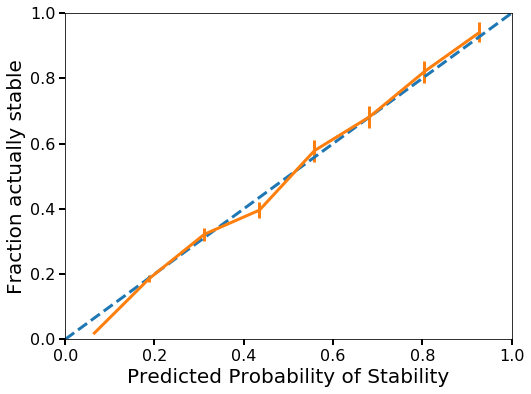

In [20]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

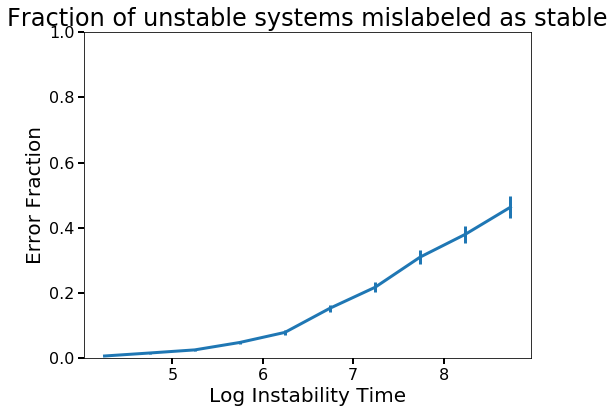

In [21]:
thresh = 0.34 # for 10% FPR
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, thresh, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')